In [12]:
from typing import Union, Optional, Callable
import numpy as np
import scipy as sc

from qiskit.circuit import QuantumCircuit
from qiskit.opflow import (
    OperatorBase,
    PauliSumOp,
)
from qiskit.providers import Backend
from qiskit.quantum_info import Statevector

from surfer.qfi import ReverseQFI
from surfer.gradient import ReverseGradient


class VarQITE:
    """Exact imaginary time evolution based on matrix exponentiation."""

    def __init__(
        self,
        ansatz: QuantumCircuit,
        initial_parameters: np.ndarray,
        regularization: float = 0.01,
        lse_solver: Optional[Callable[[np.ndarray, np.ndarray], np.ndarray]] = None,
    ) -> None:
        """
        Args:
            ansatz: The parameterized circuit used for the variational time evolution.
            initial_parameters: The initial parameters for the circuit.
            backend: The backend to run the circuits on.
            perturbation: The small perturbation to estimate the gradients at the current parameters.
        """
        self.ansatz = ansatz
        self.initial_parameters = initial_parameters
        self.regularization = regularization

        if lse_solver is None:
            lse_solver = np.linalg.solve

        self.lse_solver = lse_solver

    def evolve(
        self, hamiltonian: OperatorBase, final_time: float, timestep: float
    ) -> dict:
        if not isinstance(hamiltonian, PauliSumOp):
            raise ValueError("Hamiltonian must be a PauliSumOp.")
        hamiltonian = hamiltonian.primitive.to_matrix(sparse=True)

        energy = self._get_energy_evaluation(hamiltonian)
        qgt = self._get_qgt_evaluation()
        b = self._get_b_evaluation(hamiltonian)

        times = [0]
        energies = [energy(self.initial_parameters)]
        x = [self.initial_parameters]
        qgts = []
        bs = []

        while times[-1] < final_time:
            qgts.append(qgt(x[-1]))
            bs.append(b(x[-1]))
            update = self.lse_solver(
                qgts[-1] + self.regularization * np.identity(x[-1].size), bs[-1]
            ).real
            x.append(x[-1] + timestep * update)
            energies.append(energy(x[-1]))
            times.append(times[-1] + timestep)

        # build the final result object
        result = {"times": times, "energies": energies, "x": x, "qgt": qgts, "b": b}
        return result

    def _get_energy_evaluation(self, hamiltonian):
        def evaluate_energy(parameters):
            state = Statevector(self.ansatz.bind_parameters(parameters)).data
            energy = np.conj(state.T).dot(hamiltonian.dot(state))
            if np.abs(np.imag(energy)) > 1e-10:
                raise RuntimeError(f"Energy is not real: {energy}")
            return np.real(energy)

        return evaluate_energy

    def _get_qgt_evaluation(self):
        qfi = ReverseQFI(do_checks=False)

        def evaluate_qgt(parameters):
            return qfi.compute(self.ansatz, parameters) / 4

    
        return evaluate_qgt

    def _get_b_evaluation(self, hamiltonian):
        gradient = ReverseGradient(do_checks=False)

        def evaluate_b(parameters):
            return -np.real(gradient.compute(hamiltonian, self.ansatz, parameters)) / 2

        return evaluate_b

In [64]:
from qiskit.circuit.library import EfficientSU2
from qiskit.opflow import PauliSumOp

circuit = EfficientSU2(num_qubits=2, reps=1)
x0 = np.zeros(circuit.num_parameters)
hamiltonian = PauliSumOp.from_list([("XI", -1), ("IX", -1), ("ZZ", 0.1)])

In [65]:
varqite = VarQITE(circuit, x0)
result = varqite.evolve(hamiltonian, final_time=1, timestep=0.01)

In [60]:
np.linalg.matrix_rank

<function numpy.linalg.matrix_rank(M, tol=None, hermitian=False)>

In [61]:
times = result["times"][1:]
qgts = result["qgt"]


In [62]:
print(circuit.num_parameters)

24


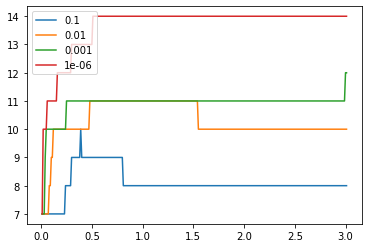

In [63]:
import matplotlib.pyplot as plt

for tol in [0.1, 0.01, 0.001, 1e-6]:
    ranks = [np.linalg.matrix_rank(qgt, tol=tol, hermitian=True) for qgt in qgts]
    plt.plot(times, ranks, label=tol)
plt.legend()

In [68]:
def get_ranks(reps, tol=1e-6):
    circuit = EfficientSU2(num_qubits=2, reps=reps)
    x0 = np.zeros(circuit.num_parameters)
    varqite = VarQITE(circuit, x0)
    result = varqite.evolve(hamiltonian, final_time=1, timestep=0.01)
    ranks = [np.linalg.matrix_rank(qgt, tol=tol, hermitian=True) for qgt in result["qgt"]]
    return result["times"], ranks

In [69]:
times = []
repranks = {}
for reps in [1, 2, 3, 4, 5]:
    print("rep", reps)
    times, ranks = get_ranks(reps)
    repranks[reps] = ranks

rep 1
rep 2
rep 3
rep 4
rep 5


In [73]:
num_qubits = 2
partial_ranks = {reps: np.array(ranks) / (2 * num_qubits * (reps + 1)) for reps, ranks in repranks.items()}

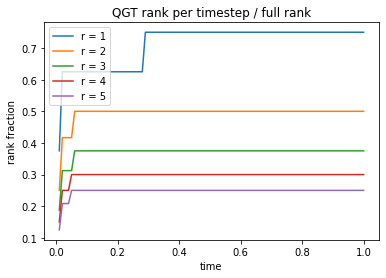

In [75]:
for rep, partial_rank in partial_ranks.items():
    plt.plot(times[1:], partial_rank, label=f"r = {rep}")
    
plt.title("QGT rank per timestep / full rank")
plt.xlabel("time")
plt.ylabel("rank fraction")
plt.legend()